<a href="https://colab.research.google.com/github/donghun1214/ML/blob/main/Colaboratory%EC%97%90_%EC%98%A4%EC%8B%A0_%EA%B2%83%EC%9D%84_%ED%99%98%EC%98%81%ED%95%A9%EB%8B%88%EB%8B%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 1s 803ms/step


<ipython-input-12-5c6cc6e858f4>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


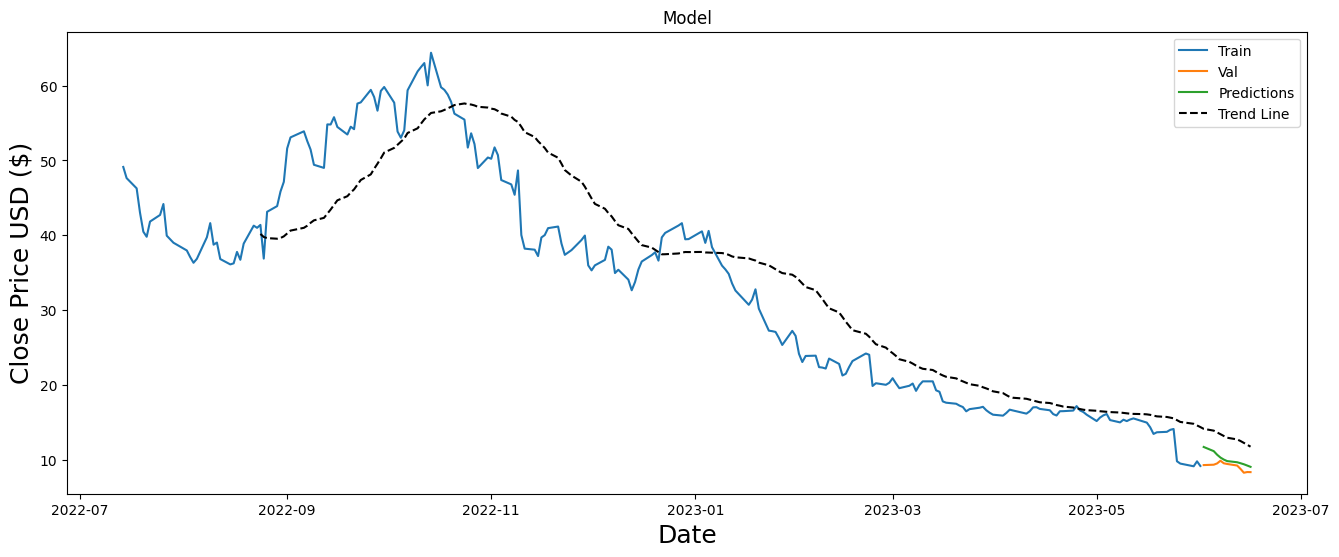

In [12]:
import pandas_datareader.data as datareader
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = yf.download('NVDS', start='2018-01-01', end='2023-06-17')

from sklearn.preprocessing import MinMaxScaler
data = df.filter(['Close'])  #종가 데이터
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .95))  #전체 데이터 95%를 훈련데이터로

#LSTM 들어가기 전 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
train_data = scaled_data[0: int(training_data_len), :]

x_train = []
y_train = []

for i in range(30, len(train_data)):
    x_train.append(train_data[i - 30 : i, 0])  #1~29일 간의 데이터 x_train
    y_train.append(train_data[i, 0]) #30일 (정답)데이터 y_train

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #RNN 의 입력층은 3D로 이루어진다 (샘플 수, 타임스텝, 피처 수)


from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# 모델 빌드
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))  #LSTM 층을 2개 연속으로 쓰기 위해선 return_sequences = true 해야 됨.
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(x_train, y_train, batch_size=1, epochs=1)
test_data = scaled_data[training_data_len - 30: , :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(30, len(test_data)):
    x_test.append(test_data[i - 30 : i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.plot(data['Close'].rolling(window=30).mean(), label='Trend Line', linestyle='--', color='black')  # 추세선 추가
plt.legend(['Train', 'Val', 'Predictions', 'Trend Line'], loc='upper right')
plt.show()